# Mobile Net Transfer Learning

Loading the pre-trained comvolutional models, removing the last layer and train with small data set.

In [1]:
#from keras.applications import ResNet50
#from keras.applications import InceptionV3
#from keras.applications import Xception
#from keras.applications import VGG16
#from keras.applications import VGG19


In [2]:
#from keras.applications.mobilenet import MobileNet


In [3]:
#MobileNet = MobileNet()
#ResNet = ResNet50()
#XceptionNet = Xception()
#VGG16 = VGG16()
#VGG19 = VGG19()

In [4]:
#InceptionV3Net = InceptionV3(input_shape=(299,299,3))


In [5]:
#XceptionNet = Xception()

In [6]:
#ResNet.summary()

In [7]:
import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Reshape, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.initializers import glorot_uniform
import matplotlib.pyplot as plt
%matplotlib inline

import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

from sklearn import decomposition
from sklearn.preprocessing import StandardScaler

from Transfer_learning_utils import convert_to_one_hot, loading_dataset, evaluate_model

Using TensorFlow backend.


In [8]:
from keras.applications.mobilenet import MobileNet
MobileNet = MobileNet()
MobileNet.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (Activation)      (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (Activation)  (None, 112, 112, 32)      0         
__________

## load training and testing data

In [51]:
selected_classes = ['garfield','barrel','beaver','camera','cannon','car_side','cellphone','crab','crayfish','crocdile','llama','lobster','lotus','pyramid','sunflower']
folderpath = './../../../../../projects/computerVision/imageRecognition/Caltech101_Dataset/101_ObjectCategories/'

In [52]:
X_train, Y_train, X_test, Y_test = loading_dataset(folderpath = folderpath, classes = selected_classes)

# Convert training and test labels to one hot matrices
Y_train = convert_to_one_hot(Y_train, len(selected_classes)).T
Y_test = convert_to_one_hot(Y_test, len(selected_classes)).T

In [53]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 698
number of test examples = 174
X_train shape: (698, 224, 224, 3)
Y_train shape: (698, 15)
X_test shape: (174, 224, 224, 3)
Y_test shape: (174, 15)


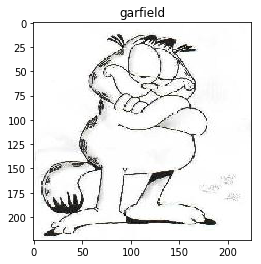

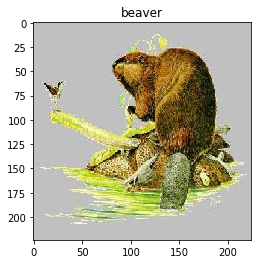

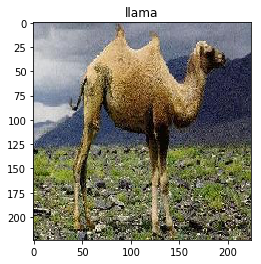

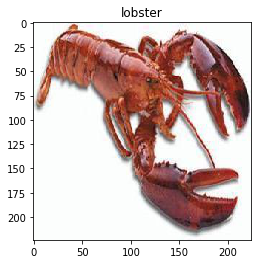

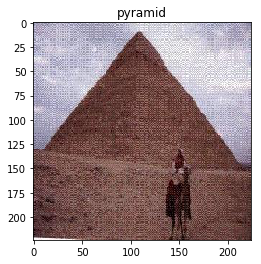

In [54]:
for i in range(5):
    plt.figure()
    plt.imshow(X_train[i]/255.)
    plt.title(selected_classes[np.argmax(Y_train[i])])

## Add new fianl dense layer, set MobileNet layers non-trainable

In [55]:
for layer in MobileNet.layers:
    layer.trainable = False

### Note for Mobile Net
The last 3 layers of MobileNet are conv2d, softmax activation and reshape. We need to 
1. Remove the last reshape
2. Remove the 2nd last layer (softmax activation layer).
3. Attach a new reshape layer to the conv2d layer to change the shape from (None, 1,1, 1000) to (None, 1000)
4. Attach a dense layer for classfication with softmax activation 

In [56]:
last_kept_MobileNetlayer = MobileNet.layers[-3]
n_last_kept_dim = int(last_kept_MobileNetlayer.output.shape[3])

new_reshape = Reshape((n_last_kept_dim,),name = 'my_new_reshape')(last_kept_MobileNetlayer.output)
new_dense = Dense(len(selected_classes), activation='softmax', kernel_initializer = glorot_uniform(seed=0))(new_reshape)

In [57]:
myMobileNet = Model(input = MobileNet.input, output = new_dense)

/home/xiang/miniconda3/envs/ML/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  """Entry point for launching an IPython kernel.


In [58]:
myMobileNet.compile(optimizer = 'adam', loss = 'categorical_crossentropy',metrics = ['accuracy'])

In [59]:
myMobileNet.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (Activation)      (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)      128       
_________________________________________________________________
conv_dw_1_relu (Activation)  (None, 112, 112, 32)      0         
__________

In [60]:
featureModel = Model(input = myMobileNet.input, output = myMobileNet.layers[-2].output)

/home/xiang/miniconda3/envs/ML/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("my...)`
  """Entry point for launching an IPython kernel.


In [63]:
nTrain = X_train.shape[0]
nTest = X_test.shape[0]

nFeature = int(featureModel.output.shape[1])

X_train_feature = np.zeros((nTrain, nFeature))
X_test_feature  = np.zeros((nTest, nFeature))

In [64]:
batch_size = 10
for i in range(0,nTrain,batch_size):
    iEnd = min([nTrain, i+batch_size])
    print('computing features for training data %d - %d' % (i, iEnd-1))
    X_train_feature[i:iEnd] = featureModel.predict(X_train[i:iEnd])    

computing features for training data 0 - 9
computing features for training data 10 - 19
computing features for training data 20 - 29
computing features for training data 30 - 39
computing features for training data 40 - 49
computing features for training data 50 - 59
computing features for training data 60 - 69
computing features for training data 70 - 79
computing features for training data 80 - 89
computing features for training data 90 - 99
computing features for training data 100 - 109
computing features for training data 110 - 119
computing features for training data 120 - 129
computing features for training data 130 - 139
computing features for training data 140 - 149
computing features for training data 150 - 159
computing features for training data 160 - 169
computing features for training data 170 - 179
computing features for training data 180 - 189
computing features for training data 190 - 199
computing features for training data 200 - 209
computing features for training dat

In [65]:
for i in range(0,nTest,batch_size):
    iEnd = min([nTest, i+batch_size])
    print('computing features for test data %d - %d' % (i, iEnd-1))
    X_test_feature[i:iEnd] = featureModel.predict(X_test[i:iEnd])   

computing features for test data 0 - 9
computing features for test data 10 - 19
computing features for test data 20 - 29
computing features for test data 30 - 39
computing features for test data 40 - 49
computing features for test data 50 - 59
computing features for test data 60 - 69
computing features for test data 70 - 79
computing features for test data 80 - 89
computing features for test data 90 - 99
computing features for test data 100 - 109
computing features for test data 110 - 119
computing features for test data 120 - 129
computing features for test data 130 - 139
computing features for test data 140 - 149
computing features for test data 150 - 159
computing features for test data 160 - 169
computing features for test data 170 - 173


In [66]:
pca = decomposition.PCA(n_components = 2)

In [67]:
x_std = StandardScaler().fit_transform(X_train_feature)
x_feature_pca = pca.fit_transform(x_std)

In [68]:
Y_train_label = np.argmax(Y_train,axis=1)

Text(0.5,1,'feature space')

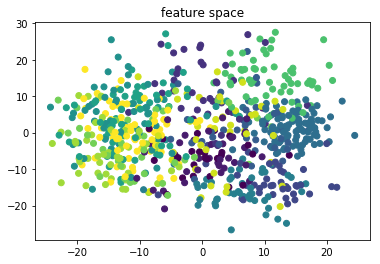

In [69]:
plt.scatter(x_feature_pca[:,0],x_feature_pca[:,1],c=Y_train_label)
plt.title('feature space')

### Note:
Before we do anything, the n-1 layers of MobileNet is already able to distinguage different classes. Here we compute the feature vectors of each training and testing data set, and plot the feature vectors (the first two dimensions in the pca space) colored by their labels. Note that there are some level of separation already between clusters. Compared to VGG, the clusters are less separated.

In [70]:
final_layer_input = Input(shape=(nFeature,))
final_layer_dense = Dense(len(selected_classes), activation='softmax', kernel_initializer = glorot_uniform(seed=0))(final_layer_input)
myMobileNet_patch = Model(inputs = final_layer_input, outputs = final_layer_dense)
myMobileNet_patch.compile(optimizer = 'adam', loss = 'categorical_crossentropy',metrics = ['accuracy'])

In [71]:
myMobileNet_patch.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 1000)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 15)                15015     
Total params: 15,015
Trainable params: 15,015
Non-trainable params: 0
_________________________________________________________________


In [84]:
myMobileNet_patch.fit(X_train_feature, Y_train, epochs = 10, batch_size = 64)

Epoch 1/10
698/698 [==============================] - 0s 51us/step - loss: 0.0029 - acc: 1.0000
Epoch 2/10
698/698 [==============================] - 0s 38us/step - loss: 0.0028 - acc: 1.0000
Epoch 3/10
698/698 [==============================] - 0s 35us/step - loss: 0.0027 - acc: 1.0000
Epoch 4/10
698/698 [==============================] - 0s 34us/step - loss: 0.0026 - acc: 1.0000
Epoch 5/10
698/698 [==============================] - 0s 41us/step - loss: 0.0025 - acc: 1.0000
Epoch 6/10
698/698 [==============================] - 0s 42us/step - loss: 0.0025 - acc: 1.0000
Epoch 7/10
698/698 [==============================] - 0s 46us/step - loss: 0.0024 - acc: 1.0000
Epoch 8/10
698/698 [==============================] - 0s 39us/step - loss: 0.0023 - acc: 1.0000
Epoch 9/10
698/698 [==============================] - 0s 39us/step - loss: 0.0022 - acc: 1.0000
Epoch 10/10
698/698 [==============================] - 0s 47us/step - loss: 0.0022 - acc: 1.0000


In [85]:
#the following code will take long time because we are computing the feature vector for each training data repeatedly

#myVGGNet.fit(X_train, Y_train, epochs = 2, batch_size = 32)

In [86]:
#evaluate_model(myVGGNet, X_train, Y_train, X_test, Y_test, maxItem = 20)

In [87]:
#prediction_result = myVGGNet.predict(X_test[0:10])
#predicted_labels = np.argmax(prediction_result,axis=1)

In [88]:
evaluate_model(myMobileNet_patch, X_train_feature, Y_train, X_test_feature, Y_test, maxItem = 1000)

Performance on Training data set (698)
698/698 [==============================] - 0s 34us/step
Loss = 0.00212328529444
Train Accuracy = 1.0
Performance on Testing data set (174)
174/174 [==============================] - 0s 56us/step
Loss = 0.225489330617
Test Accuracy = 0.919540229885


In [89]:
prediction_result = myMobileNet_patch.predict(X_test_feature)
predicted_labels = np.argmax(prediction_result,axis=1)
prediction_conf = np.max(prediction_result, axis = 1)

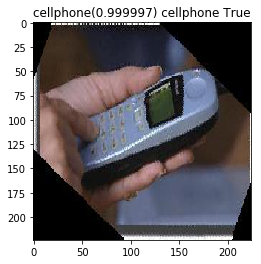

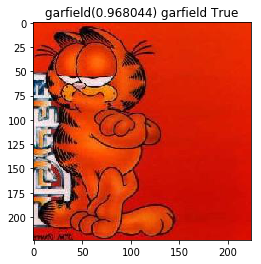

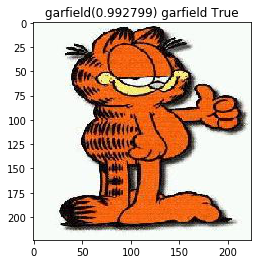

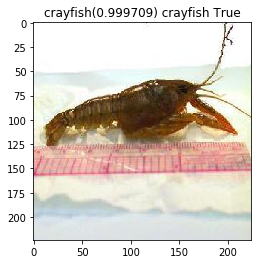

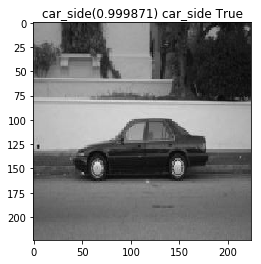

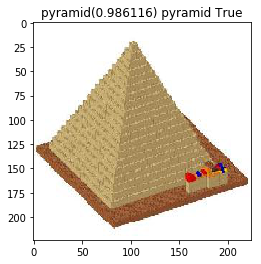

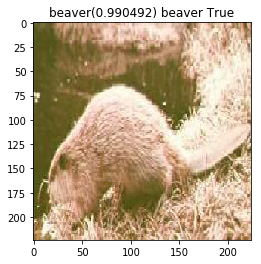

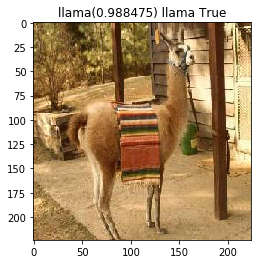

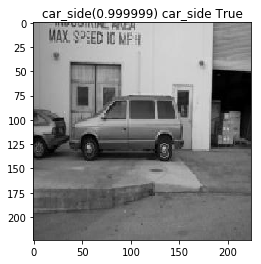

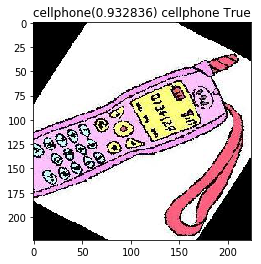

In [90]:
for i in range(10):
    actu = np.argmax(Y_test[i])
    plt.figure()
    plt.imshow(X_test[i]/255.)
    plt.title(selected_classes[predicted_labels[i]] + '(' + str(prediction_conf[i])+') ' + selected_classes[actu] + ' ' + str(predicted_labels[i]==actu))    

## Bravo!
Using only ~400 images of 5 classes, the Conv model transfer-learned from MobileNet model reached 100% accuracy in training data set and 95.5% accuracy in test data set. Training the model takes almost instantaneous time because the feature vectors computed from the (n-1) layers of Mobile Net already contained most information. 

## Notes on Mobile Net
Mobile Network is a small size Convolutional neural network model. It contains only 4M trainable parameters. Computing the feature vectors using pre-trained MobileNet takes much short time than VGG16 or VGG19. Also the model is only 3.3% the size of VGG16

In [ ]:
plot_model(model, to_file='model.png')
SVG(model_to_dot(model).create(prog='dot', format='svg'))